In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
import gc
import copy
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.base import BaseEstimator, ClassifierMixin
from os import listdir
from os.path import isfile, join
import math
from datetime import datetime

In [2]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.299 * r + 0.5870 * g + 0.1140 * b
    return gray

def blend_images(orig, four, alpha = 0.8, colH = 10):
    orig_img = Image.open(orig).convert('RGBA')
    fourier_img = Image.open(four).convert('RGBA')
        
    orig_img = orig_img.resize(((fourier_img.size[0], fourier_img.size[1])), Image.BICUBIC)
    
    img = fourier_img
    A = img.getchannel('A')

    # Convert to HSV and save the V (Lightness) channel
    V = img.convert('RGB').convert('HSV').getchannel('V')

    # Synthesize new Hue and Saturation channels using values from colour picker
    colpickerH, colpickerS = colH, 255
    newH=Image.new('L',img.size,(colpickerH))
    newS=Image.new('L',img.size,(colpickerS))

    # Recombine original V channel plus 2 synthetic ones to a 3 channel HSV image
    HSV = Image.merge('HSV', (newH, newS, V))

    # Add original Alpha layer back in
    R,G,B = HSV.convert('RGB').split()
    RGBA = Image.merge('RGBA',(R,G,B,A))
    
    new_img = Image.blend(orig_img, RGBA, alpha)
    return new_img

def calculate_log(picture,threshold=0.5):
    log = np.log(np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
    fourier_abs = np.abs(log)
    return fourier_abs

def get_ceps(picture):
    hm_len = picture.shape[0]
    bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
    bw2d = bw2d * bw2d.T
    log = np.log(np.abs(np.fft.fft2(picture * bw2d)))
    fourier_abs = np.abs(np.fft.ifft2(log))
    threshold = 0.5
    fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
    fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0

    return fourier_abs

def f2(template_picture, y, x, l, w = 3):
    h = template_picture.shape[0]
    s = 0
    for i in range(w+1):
        y = y+i
        y = (y if y >= 0 else 0) if y <= h-1 else h-1
        s += template_picture[y, x]
        if (y, x) not in l:
            l.append((y, x))
        y = y-i
        y = (y if y >= 0 else 0) if y <= h-1 else h-1
        if (y, x) not in l:
            l.append((y, x))
        s += template_picture[y, x]
        
    return s

def f1(template_picture, dif=10):
    h = template_picture.shape[0]
    q = h // 2 - 1
    res = np.zeros(dif)
    l = [[]] * dif
    coef = [0] * dif
    for idx, phi in enumerate(np.linspace(-90, 90, num=dif)):
        even_phi = int(round(phi))
        k = math.pi * phi / 180
        coef[idx] = k
        b = (1 - k) * q
        s = 0
        l1 = []
        for x in range(h):
            y = round(k*x+b)
            y = int(y if y <= h - 1 else h-1)
            y = int(y if y >= 0 else 0)
            
#             print(y,x)
            s += f2(template_picture, y, x, l1, w=1)
        l[idx] = l1
#         print(s)
        res[idx] = s
#     print(np.argmax(res) - int(res.shape[0]//2))
#     print(res)
    max_idx = np.argmax(res)
    p = np.zeros((template_picture.shape[0], template_picture.shape[0]))
    for t in l[max_idx]:
        p[t] = 1
#     print(res[max_idx])
#     plt.imsave('line.png', p, cmap='gray')
#     return -coef[max_idx]
    return p

class Cepstrum:
    def __init__(self, picture, batch_size=64, step=0.25):
        gc.enable()
        self.batch_size = batch_size
        self.step = step
        self.x_batches = int(picture.shape[1] // (batch_size * step) - int(1/step))
        self.y_batches = int(picture.shape[0] // (batch_size * step) - int(1/step))
        self.picture = copy.deepcopy(picture)
        plt.imsave('orig_img.png', self.picture, cmap='gray')

    def get_square(self):
        pixel_step = int(self.batch_size * self.step)
        for y in range(self.y_batches):
            for x in range(self.x_batches):
#                 yield Cepstrum.calculate_cepstrum(self.picture[y * pixel_step : y * pixel_step + self.batch_size,
#                                    x * pixel_step : x * pixel_step + self.batch_size ])
                yield self.swap_quarters(Cepstrum.calculate_cepstrum(self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size ]))
#                 yield self.picture[y * pixel_step : y * pixel_step + self.batch_size,
#                                    x * pixel_step : x * pixel_step + self.batch_size ]

    def ft_array(self):
        temp_obj = np.ndarray((self.batch_size, self.batch_size), dtype='float')
        a = np.array(list(self.get_square()))
        b = np.copy(a)
        for idx, q in enumerate(a):
            b[idx] = f1(q)
#             plt.imshow(b[idx], cmap='gray')
#             break
        self.output = a.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        self.lines_img = b.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        
    def make_big_image(self, threshold=0.5):
        try:
            temp = [ 0 ] * self.y_batches
            temp1 = [ 0 ] * self.y_batches
            for y in range(self.y_batches):
                temp[y] = np.hstack(self.output[y, :, :, :])
                temp1[y] = np.hstack(self.lines_img[y, :, :, :])
            self.big_image = np.vstack(temp)
            self.lines_img = np.vstack(temp1)
            return self.threshold_big_image()
            
            return self.big_image
        except AttributeError:
            print("!!! Use ft_array() function first !!!")
            
    def hamming(picture):
        hm_len = picture.shape[0]
        bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
        bw2d = bw2d * bw2d.T
        return picture * bw2d
    
    def calculate_cepstrum(picture,threshold=0.5):
        log = np.log(1 + np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
        fourier_abs = np.abs(np.fft.ifft2(log))
        fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
        fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
        
#         fourier_abs *= (1.0/fourier_abs.max())
#         fourier_abs[fourier_abs < 0.1] = 0
        return fourier_abs
    
    def threshold_big_image(self, threshold=0.5):
        fourier_abs = self.big_image
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold] = 0
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold] = 0
        
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs < 0.1] = 0
        return self.big_image
    
    def swap_quarters(self, picture):
        out_pict = copy.deepcopy(picture)
        batch_size = picture.shape[0]
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, : batch_size//2])
        out_pict[: batch_size//2, : batch_size//2] = out_pict[batch_size//2 :, batch_size//2 :]
        out_pict[batch_size//2 :, batch_size//2 :] = temp_pict
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, batch_size//2 :])
        out_pict[: batch_size//2, batch_size//2 :] = out_pict[batch_size//2 :, : batch_size//2]
        out_pict[batch_size//2 :, : batch_size//2] = temp_pict[:]
        return out_pict
    

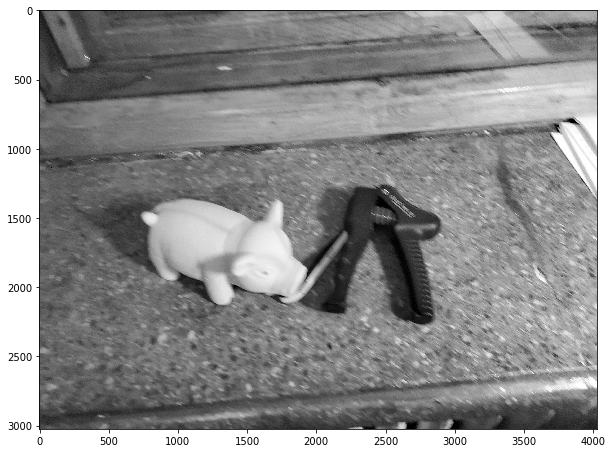

In [5]:
work_dir = "../pict/"
s = str(datetime.now())

save_dir = '../res_' + s[8:10] + '_' + s[5:7] + '/'

# filename = "mb0.jpg"
filename = "pig_lil.jpg"

img = rgb2gray(plt.imread(work_dir + filename))

#fig, (ax1, ax2) = plt.subplots(1, 2)
plt.figure(figsize=(10,230))
plt.imshow(img, cmap='gray')
#ax2.imshow(b)

In [9]:
# c = Cepstrum(img[1800 : 3000, 500 : 2000], batch_size=128, step=0.25)
c = Cepstrum(img, batch_size=256, step=0.5)
# c = Cepstrum(img)
c.ft_array()

q = c.make_big_image()
plt.imsave('big_img.png', q, cmap='gray')
plt.imsave('lines_img.png', c.lines_img, cmap='gray')

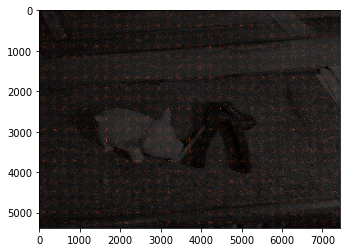

In [10]:
d = blend_images('orig_img.png', 'big_img.png')
imshow(np.asarray(d))
d.save('temp_vis.png')

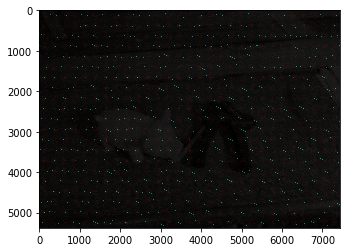

In [11]:
d = blend_images('temp_vis.png', 'lines_img.png', alpha=0.5, colH = 120)
imshow(np.asarray(d))
d.save('good_visualisation.png')

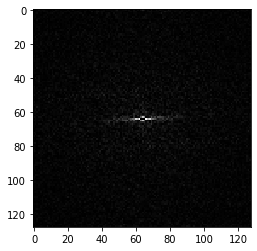

In [32]:
# a = c.output[9, 8]
a = c.output[8, 6]
# a = c.output[9, 0] #bad one
plt.imshow(a, cmap='gray')
plt.imsave('local_cep1.png', a, cmap='gray')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


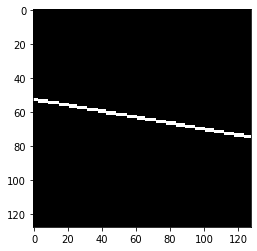

In [33]:
print(f1(a))
plt.imshow(f1(a), cmap='gray')

In [ ]:
filenames = ['mb0.jpg', 'mb1.jpg', 'pig_big', 'pig_lil']
b_sizes = [32, 64, 128]
steps = [0.25, 0.5]

for filename in filenames:
# filename = 'cm.PNG'
    for batch_size in b_sizes:
        for step in steps:
            img = rgb2gray(plt.imread(work_dir + filename))
            c = Cepstrum(img[2000:3500, 1000:2800], batch_size=batch_size, step=step)
            c = Cepstrum(img, batch_size=batch_size, step=step)
            c.ft_array()

            q = c.make_big_image()
            plt.imsave('big_img.png', q, cmap='gray')

            d = blend_images('orig_img.png', 'big_img.png')
            d.save(save_dir + filename[:-4] + "_" + str(c.batch_size) + '_' + str(c.step) + '_visualisation.png')